In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import json
import os
import openai
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())  # read local .env file

import time
import pickle

import handoff_eval

# Load data

In [3]:
data_path = "../data/ai_ml_take_home"
ground_truth_path = os.path.join(data_path, "ground_truth")
model_outputs_path = os.path.join(data_path, "model_outputs")

In [4]:
ground_truth_data = handoff_eval.data_preparation.load_json_files(ground_truth_path)
model_output_data = handoff_eval.data_preparation.load_json_files(model_outputs_path)

# Check models evaluation time

2025-03-21 10:24:17,056 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-21 10:24:17,065 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


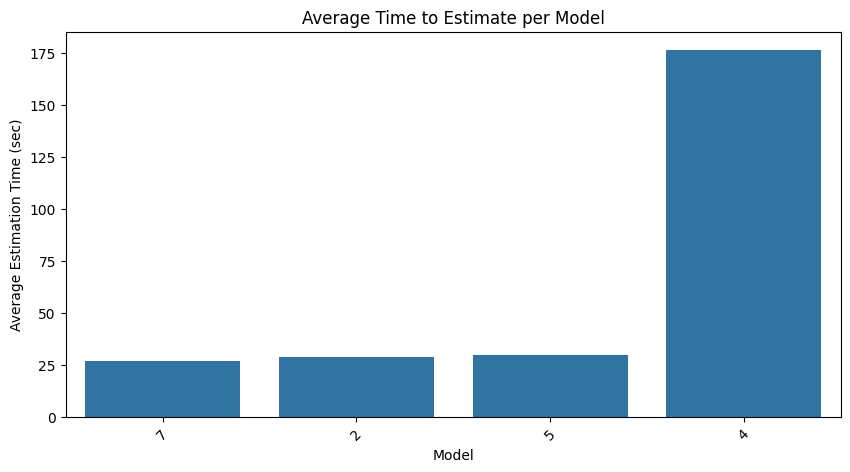

In [5]:
# Avg time by model
df_avg_time = handoff_eval.evaluation.plot_avg_estimation_time(model_output_data)

# Evaluation run

In [6]:
# run_number = 2
# run_number = 3
run_number = 4
load_run = True
# load_run = False
save_run = False
# save_run = True

eval_dir = "../data/evaluations"
# Create the "evaluations" folder if it does not exist
os.makedirs(eval_dir, exist_ok=True)
eval_file_path = os.path.join(eval_dir, f"matched_pairs_dict_{run_number}.pkl")

In [7]:
if load_run:
    with open(eval_file_path, "rb") as f:
        matched_pairs_dict = pickle.load(f)

else:
    start_time = time.time()

    async def run_async_processing():
        return await handoff_eval.data_preparation.process_all_models_async(model_output_data, ground_truth_data)

    matched_pairs_dict = await run_async_processing()

    end_time = time.time()
    total_time = end_time - start_time
    print(f"process_all_models_async - total execution time: {total_time:.2f} seconds")

    if save_run:
        # Save the dictionary to a pickle file
        with open(eval_file_path, "wb") as f:
            pickle.dump(matched_pairs_dict, f)
# process_all_models_async - total execution time: 41.90 seconds

2025-03-21 10:24:18,370 - INFO - handoff_eval - Step 1: Generating matched_pairs for all models.
2025-03-21 10:24:23,992 - INFO - handoff_eval - Step 2: Processing all matched_pairs asynchronously.
2025-03-21 10:24:48,501 - INFO - handoff_eval - Step 3: Updating matched_pairs_dict with processed results.
2025-03-21 10:24:48,502 - INFO - handoff_eval - Processing complete.


process_all_models_async - total execution time: 30.13 seconds


# Visualize main metrics by model

2025-03-21 10:24:48,603 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-21 10:24:48,610 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


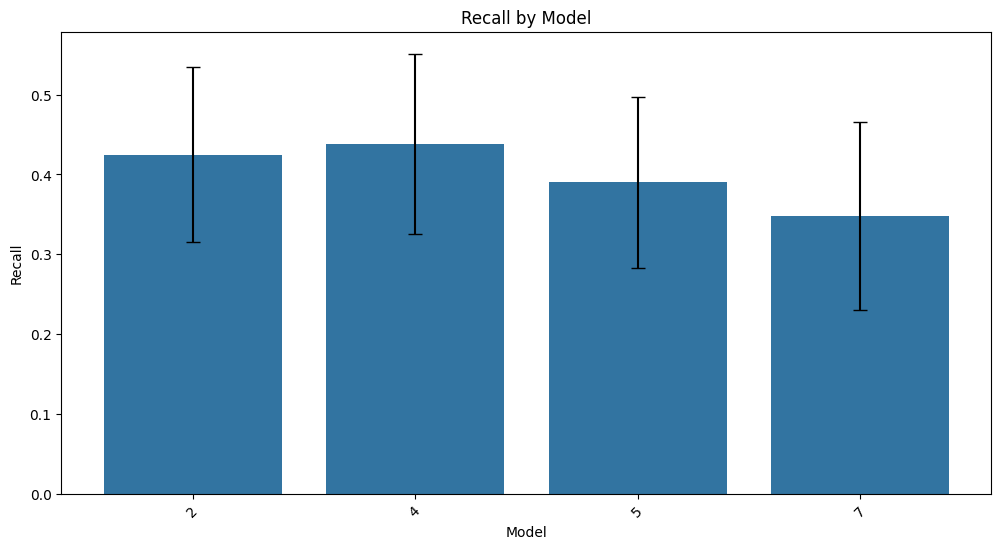

2025-03-21 10:24:48,799 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-21 10:24:48,805 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


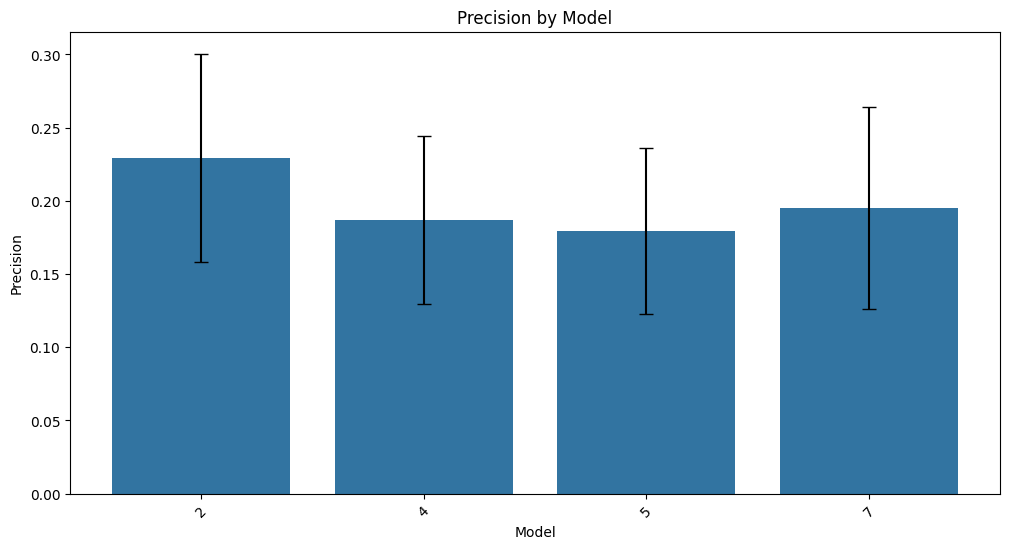

2025-03-21 10:24:48,958 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-21 10:24:48,963 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


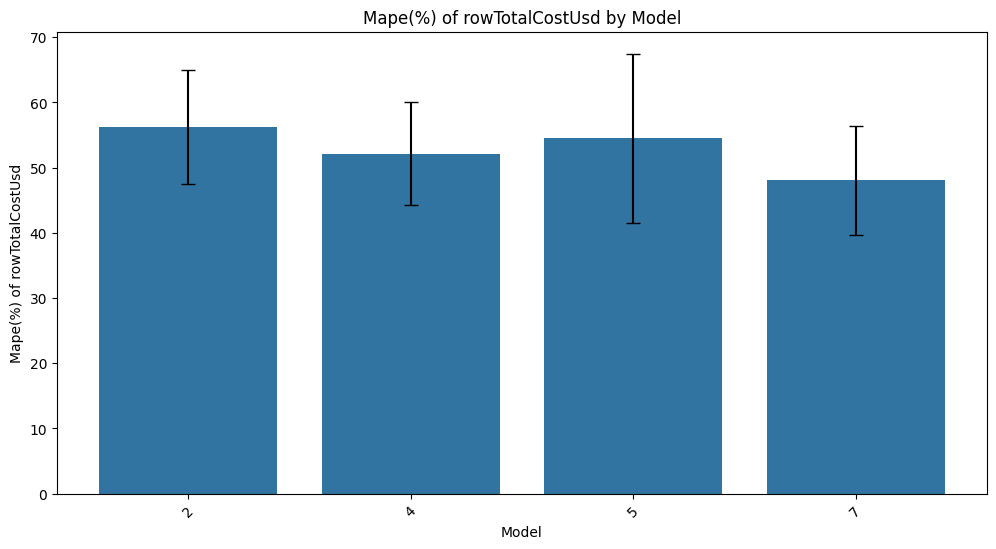

In [8]:
# --- Plotting ---
confidence=0.95
x = "model"
# Recall
error_type = "recall"
df_metrics = handoff_eval.evaluation.compute_model_metrics_df(matched_pairs_dict, metric=None, error_type=error_type)
handoff_eval.evaluation.plot_model_metrics(df_metrics, x=x, metric_name=error_type.capitalize(), confidence=confidence)

# Precision
error_type = "precision"
df_metrics = handoff_eval.evaluation.compute_model_metrics_df(matched_pairs_dict, metric=None, error_type=error_type)
handoff_eval.evaluation.plot_model_metrics(df_metrics, x=x, metric_name=error_type.capitalize(), confidence=confidence)

# Mape of rowTotalCostUsd
# Filter to keep only llm identified similar tasks before to calculate the residuals
filtered_matched_pairs_dict = handoff_eval.data_preparation.filter_similar_task(matched_pairs_dict)
metric = "rowTotalCostUsd"
error_type = "mape"
metric_name = f"{error_type.capitalize()}(%) of {metric}"
df_metrics = handoff_eval.evaluation.compute_model_metrics_df(filtered_matched_pairs_dict, metric=metric, error_type=error_type)
handoff_eval.evaluation.plot_model_metrics(df_metrics, x=x, metric_name=metric_name, confidence=confidence)

In [9]:
# Find best model based on best f1 and best MAPE
best_models = handoff_eval.evaluation.find_best_tradeoff_models(matched_pairs_dict, top_n=2)
print("Best Tradeoff Model(s):", best_models)

Best Tradeoff Model(s): {'4'}


# Investigate main metrics by example for each model

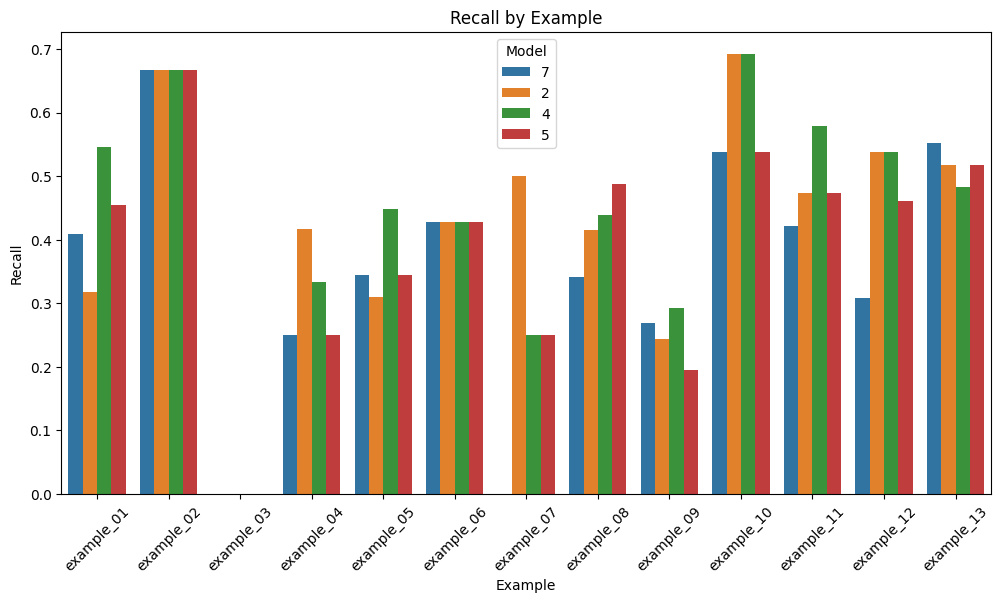

In [10]:
x = "example"
# Recall
error_type = "recall"
df_metrics = handoff_eval.evaluation.compute_model_metrics_df(matched_pairs_dict, metric=None, error_type=error_type)
handoff_eval.evaluation.plot_model_metrics(df_metrics, x=x, metric_name=error_type.capitalize())

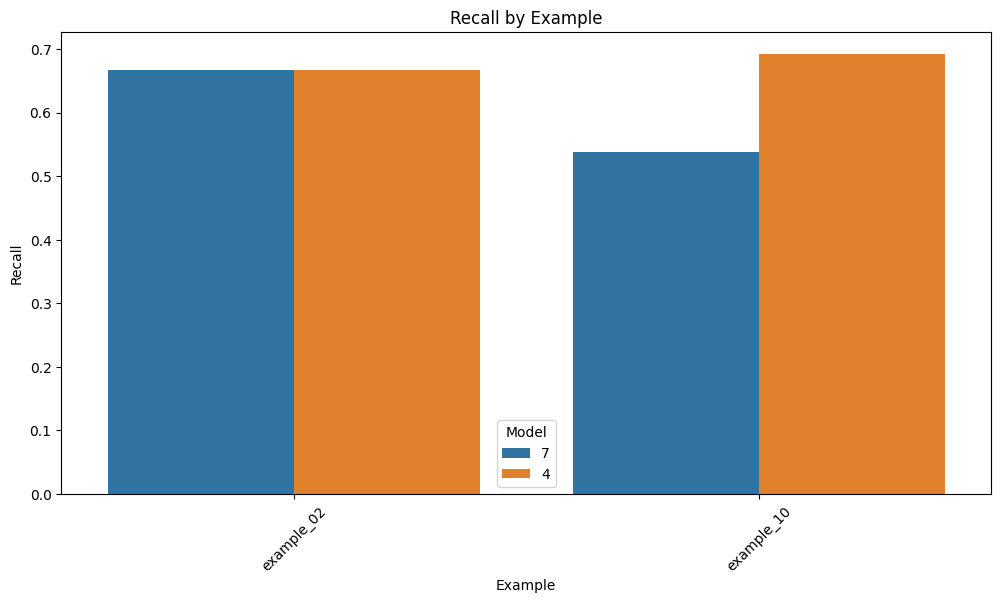

In [11]:
# Plot after filtering specific examples and models
x = "example"
# Recall
error_type = "recall"
filtered_df = handoff_eval.evaluation.filter_metrics(df_metrics, example_list=["example_02", "example_10"], model_list=["4", "7"])
handoff_eval.evaluation.plot_model_metrics(filtered_df, x=x, metric_name=error_type.capitalize())

In [12]:
# Investigate input of specific examples
print(ground_truth_data["example_02"]["input"])

I have a utility room which needs sound insulation and drywall on one wall. I would like this wall painted also. Wall is 20'x10'.


In [13]:
# Investigate matched pair (gt_, pred_) for this same example and for the best model `4`
matched_pairs_dict["4"]["example_02"]["matched_pairs_data"].iloc[:3]

,gt_label,gt_sectionName,gt_uom,gt_category,gt_qty,gt_rateUsd,gt_rowTotalCostUsd,pred_label,pred_sectionName,pred_uom,pred_category,pred_qty,pred_rateUsd,pred_rowTotalCostUsd,similar_task,justification
0,"Install Drywall at Walls: Hang, Tape, and Finish",Drywall,SF,other,200.0,2.0,400.0,1/2 inch Drywall for Walls,Drywall,SF,material,200.0,0.6,120.0,1,"yes, both labels describe the process of worki..."
1,Paint Walls - 3 Coats,Painting,SF,other,200.0,2.4,480.0,Prepare Wall Surface for Paint,Painting,SF,labor,200.0,0.3,60.0,0,"no, these labels describe different stages of ..."
2,Insulate Walls,Insulation,SF,other,200.0,2.0,400.0,R-13 Sound Insulation Batts,Insulation,SF,material,200.0,1.2,240.0,1,"yes, both labels describe the task of installi..."


In [14]:
# Calculate specific metadata (words count in this example) and plot metrics
bucket_edges = handoff_eval.utils.compute_word_count_buckets(ground_truth_data, n_buckets=3)
df_metrics_with_metadata = handoff_eval.evaluation.add_metadata_to_metrics(
    df_metrics, ground_truth_data, lambda x: handoff_eval.utils.bucketize_word_count(x, bucket_edges), "word_count_bucket"
)
df_metrics_with_metadata = handoff_eval.utils.sort_buckets(df_metrics_with_metadata, "word_count_bucket", bucket_edges)

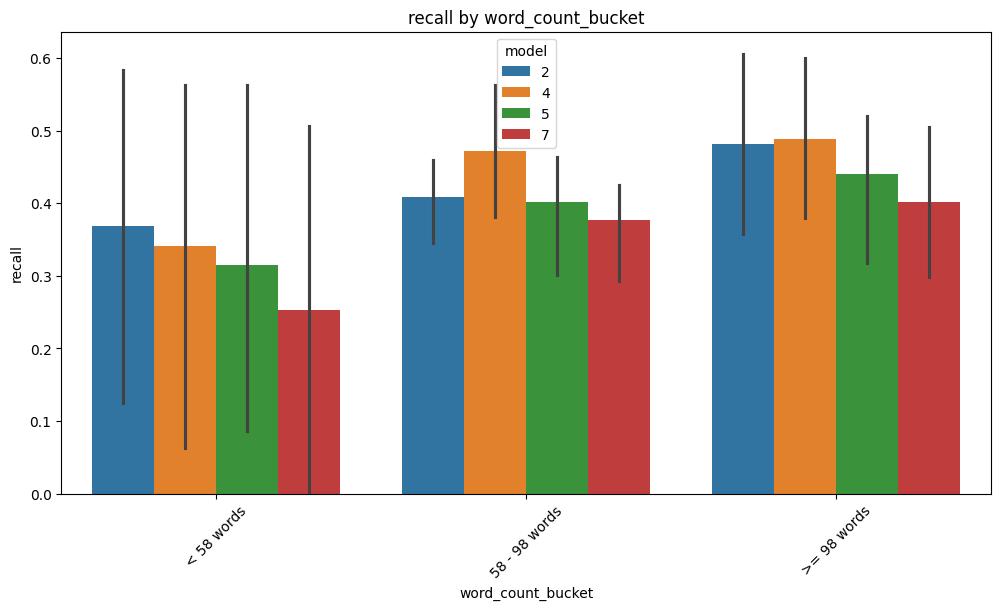

In [15]:
handoff_eval.evaluation.plot_metric_by_metadata(df_metrics_with_metadata, error_type="recall", x_column="word_count_bucket", hue_column="model")

# Simple example to illustrate the methodology

In [16]:
from handoff_eval.constants import LINE_ITEM_INFO
sel_cols = [col for pair in [(f"gt_{key}", f"pred_{key}") for key in LINE_ITEM_INFO] for col in pair]

In [17]:
matched_pairs_dict["2"]["example_01"]["matched_pairs_data"][sel_cols].head(10)

,gt_label,pred_label,gt_sectionName,pred_sectionName,gt_uom,pred_uom,gt_category,pred_category,gt_qty,pred_qty,gt_rateUsd,pred_rateUsd,gt_rowTotalCostUsd,pred_rowTotalCostUsd
0,Install Toilet,Toilet,Plumbing,Plumbing,EA,EA,other,material,1.0,1.0,400.0,250.00,400.0,250.00
1,Install Wall Tile,Shower Wall Tile,Tile,Tile,SF,SF,other,material,66.0,150.0,16.0,8.00,1056.0,1200.00
2,Install Floor Tile,Bathroom Floor Tile,Tile,Tile,SF,SF,other,material,73.0,74.0,16.0,8.00,1168.0,592.00
3,Paint Ceiling - 3 Coats,Prepare Ceiling Surfaces for Paint,Painting,Painting,SF,SF,other,material,73.0,75.0,2.4,0.30,175.2,22.50
4,Paint Walls - 3 Coats,Prepare Wall Surfaces for Paint,Painting,Painting,SF,SF,other,material,288.0,188.0,2.4,0.30,691.2,56.40
5,Demo Shower Surround,Protect Work Area and Surroundings,Demolition,Demolition,SF,SF,other,labor,66.0,75.0,2.4,0.25,158.4,18.75
6,Demo Vanity,Demo Vanity,Demolition,Demolition,EA,HRS,other,labor,1.0,1.0,80.0,65.00,80.0,65.00
7,Demo Tub,Demo Tub,Demolition,Demolition,EA,HRS,other,labor,1.0,2.0,240.0,65.00,240.0,130.00
8,Demo Plumbing Fixtures,Disposal Costs,Demolition,Demolition,EA,EA,other,labor plus material,3.0,1.0,120.0,400.00,360.0,400.00
9,Install Shower Pan,Pipe Fittings and Adhesives,Plumbing,Plumbing,EA,EA,other,material,1.0,1.0,520.0,50.00,520.0,50.00


In [18]:
import pandas as pd
pd.set_option("display.max_colwidth", None)  # Show full text in all columns

matched_pairs_dict["2"]["example_01"]["matched_pairs_data"][sel_cols[:8] + ["similar_task", "justification"]].head()

,gt_label,pred_label,gt_sectionName,pred_sectionName,gt_uom,pred_uom,gt_category,pred_category,similar_task,justification
0,Install Toilet,Toilet,Plumbing,Plumbing,EA,EA,other,material,1,"yes, both labels refer to the task involving a toilet, with ""install toilet"" specifying the installation process, and ""toilet"" likely referring to tasks related to a toilet, including installation."
1,Install Wall Tile,Shower Wall Tile,Tile,Tile,SF,SF,other,material,1,"yes, both labels refer to the installation of tile on walls, though the second specifies the location as being in a shower."
2,Install Floor Tile,Bathroom Floor Tile,Tile,Tile,SF,SF,other,material,1,"yes, both labels refer to the task of installing tile, specifically on a floor, with the second label specifying the location as a bathroom."
3,Paint Ceiling - 3 Coats,Prepare Ceiling Surfaces for Paint,Painting,Painting,SF,SF,other,material,0,"no, these labels describe different tasks; the first is about applying paint, while the second involves preparing the surface before painting."
4,Paint Walls - 3 Coats,Prepare Wall Surfaces for Paint,Painting,Painting,SF,SF,other,material,0,"no, these labels describe different stages of a painting project; the first is the application of paint, while the second involves preparing the walls before painting."


In [19]:
pd.reset_option("display.max_colwidth")

In [20]:
matched_pairs_dict["2"]["example_01"].keys()

dict_keys(['matched_pairs', 'matched_pairs_data', 'n_estimations', 'n_ground_truths', 'recall', 'precision', 'f1'])

In [21]:
matched_pairs_dict["2"].keys()

dict_keys(['example_01', 'example_02', 'example_03', 'example_04', 'example_05', 'example_06', 'example_07', 'example_08', 'example_09', 'example_10', 'example_11', 'example_12', 'example_13'])